# predicti_SOI

** 数据集 ** 


- 两列数据的气象序列, 一列是时间，一列是南方涛动指数
- 南方涛动（Southern Oscillation）是热带环流年际变化最突出、最重要的一个现象。主要指发生在东南太平洋与印度洋及印尼地区之间的反相气压振动。
- 目的：通过以前的南方涛动指数（SOI），去预测后面

** 导入模块 **

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation

Using TensorFlow backend.
/home/htfeng/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import warnings
warnings.filterwarnings('ignore')

** 导入数据 **

In [3]:
#导入数据
df = pd.read_csv('../DATA/soi.csv')
df = df.set_index('time')

In [4]:
df.head()

,SOI
time,
1951.0417,1.5
1951.1250,0.9
1951.2083,-0.1
1951.2917,-0.3
1951.3750,-0.7


** 画图 **

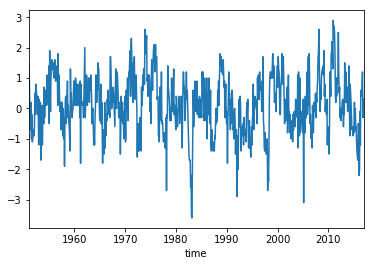

In [5]:
#画图
df['SOI'].plot()
plt.show()

** 数据预处理 **

In [9]:
#只用客运流量一列
df = pd.read_csv('../DATA/soi.csv', sep=',', usecols=[1])
data_all = np.array(df).astype(float)

In [10]:
#数据归一化
scaler = MinMaxScaler()
data_all = scaler.fit_transform(data_all)

**时间序列 ** 

In [11]:
#时间序列
sequence_length=10
data = []
for i in range(len(data_all) - sequence_length - 1):
    data.append(data_all[i: i + sequence_length + 1])
reshaped_data = np.array(data).astype('float64')
reshaped_data

array([[[ 0.78461538],
        [ 0.69230769],
        [ 0.53846154],
        ..., 
        [ 0.38461538],
        [ 0.4       ],
        [ 0.43076923]],

       [[ 0.69230769],
        [ 0.53846154],
        [ 0.50769231],
        ..., 
        [ 0.4       ],
        [ 0.43076923],
        [ 0.44615385]],

       [[ 0.53846154],
        [ 0.50769231],
        [ 0.44615385],
        ..., 
        [ 0.43076923],
        [ 0.44615385],
        [ 0.41538462]],

       ..., 
       [[ 0.47692308],
        [ 0.46153846],
        [ 0.21538462],
        ..., 
        [ 0.61538462],
        [ 0.66153846],
        [ 0.73846154]],

       [[ 0.46153846],
        [ 0.21538462],
        [ 0.24615385],
        ..., 
        [ 0.66153846],
        [ 0.73846154],
        [ 0.50769231]],

       [[ 0.21538462],
        [ 0.24615385],
        [ 0.53846154],
        ..., 
        [ 0.73846154],
        [ 0.50769231],
        [ 0.53846154]]])

** 训练集和测试集 **

In [12]:
split = 0.8
np.random.shuffle(reshaped_data)
x = reshaped_data[:, :-1]
y = reshaped_data[:, -1]
split_boundary = int(reshaped_data.shape[0] * split)
train_x = x[: split_boundary]
test_x = x[split_boundary:]

train_y = y[: split_boundary]
test_y = y[split_boundary:]

In [13]:
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))

** 搭建模型**

In [14]:
#搭建LSTM模型
model = Sequential()
model.add(LSTM(input_dim=1, output_dim=50, return_sequences=True))
print(model.layers)
model.add(LSTM(100, return_sequences=False))
model.add(Dense(output_dim=1))
model.add(Activation('linear'))

model.compile(loss='mse', optimizer='rmsprop')

** 模型预测 **

In [15]:
model.fit(train_x, train_y, batch_size=512, nb_epoch=100, validation_split=0.1)
predict = model.predict(test_x)
predict = np.reshape(predict, (predict.size, ))

Train on 561 samples, validate on 63 samples
Epoch 1/100
561/561 [==============================] - 1s 1ms/step - loss: 0.3135 - val_loss: 0.0816
Epoch 2/100
561/561 [==============================] - 0s 289us/step - loss: 0.0622 - val_loss: 0.0210
Epoch 3/100
561/561 [==============================] - 0s 306us/step - loss: 0.0219 - val_loss: 0.0235
Epoch 4/100
561/561 [==============================] - 0s 298us/step - loss: 0.0238 - val_loss: 0.0188
Epoch 5/100
561/561 [==============================] - 0s 300us/step - loss: 0.0166 - val_loss: 0.0186
Epoch 6/100
561/561 [==============================] - 0s 318us/step - loss: 0.0169 - val_loss: 0.0187
Epoch 7/100
561/561 [==============================] - 0s 302us/step - loss: 0.0177 - val_loss: 0.0191
Epoch 8/100
561/561 [==============================] - 0s 313us/step - loss: 0.0183 - val_loss: 0.0184
Epoch 9/100
561/561 [==============================] - 0s 413us/step - loss: 0.0171 - val_loss: 0.0281
Epoch 10/100
561/561 [========

** 画图比较**

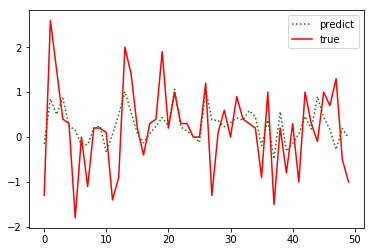

In [18]:
predict_y = scaler.inverse_transform([[i] for i in predict])
test = scaler.inverse_transform(test_y)

plt.plot(predict_y[-50:], 'g:', label='prediction')
plt.plot(test[-50:], 'r-', label='true')
plt.legend(['predict', 'true'])
plt.show()

** 成绩 **

In [30]:
import math
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
    return trainScore, testScore

In [31]:
model_score(model, train_x, train_y, test_x, test_y)

Train Score: 0.01282 MSE (0.11 RMSE)
Test Score: 0.01582 MSE (0.13 RMSE)


(0.012823279947042465, 0.015821978538801337)